# High Granularity Calorimeter (HGCAL) test beam analysis using jupyter notebooks
Matteo Bonanomi (LLR, Ecole Polytechnique, CNRS) on beahalf of the CMS HGCAL TB Group

### Abstract 
In 2027 CERN is expected to start the High-Luminosity LHC (HL-LHC) phase. HL-LHC will integrate 10 times the current luminosity, leading to a high pile-up rate and unprecedented radiation levels. In order to cope with such a harsh environment and maintain the current physics performance, a major upgrade of the LHC detectors is required. As part of the HL-LHC detector upgrade programme, the CMS experiment is developing a High Granularity Calorimeter (HGCAL) to replace the existing endcap calorimeters.

Beam tests play a fundamental role in the validation of the detector design and in the study of its physics performance. In a typical beam test environment, it is important to have quick access to data, in order to perform explorative analysis, data visualization for the main physical distributions and to run data quality monitoring. During the offline analysis it is very often necessary to run comparisons between data and simulations, to identify problematic features in data, to develop preselection and cleaning cuts, and to reconstruct different observables distributions to produce the final results by means of statistical analysis.

Jupyter Notebooks are being used more and more by physicists to face this kind of task, as they provide an interactive interface where code can be executed, documented, and the outputs can be directly produced, analyzed and visualised. The data can be access remotely without the need of downloading to a local machine.

After a brief introduction about the HGCAL, the talk will focus on the major benefits that come from the use of interactive notebooks during a test beam campaign and in the subsequent phase of data analysis.

## Table of contents
### Test beam campaign
1. [Set up the notebook for a test beam campaign](#Set-up-the-notebook-for-a-test-beam-campaign)
    1. [Loading data using the python environment](#Loading-data-using-the-python-environment)
    1. [Physics observables: reconstructed energy, longitudinal profiles and number of hits](#Physics-observables:-reconstructed-energy,-longitudinal-profiles-and-number-of-hits)
1. [Data Quality Monitoring (DQM): Event displays and preliminary sanity checks ](#Data-Quality-Monitoring-(DQM):-Event-displays-and-preliminary-sanity-checks)
    1. [Event display: a first taste of data](#Event-display:-a-first-taste-of-data)
    1. [DAQ: High vs low gain amplitudes](#DAQ:-High-vs-low-gain-amplitudes)
    1. [The result of DQM studies: spotting and masking bad features in Data](#The-result-of-DQM-studies:-spotting-and-masking-bad-features-in-Data)
1. [Effect of DQM studies on physics observables](#Effect-of-DQM-studies-on-physics-observables)

### Statystical data analysis
1. [Offline analysis: from reconstructed data to the final results](#Offline-analysis:-from-reconstructed-data-to-the-final-results)
    1. [Inputs for the statistical analysis: large amount of data](#Inputs-for-the-statistical-analysis:-large-amount-of-data)
1. [Measuring the energy resolution](#Measuring-the-energy-resolution)
    1. [Jupyter notebooks from top to bottom: the final result](#Jupyter-notebooks-from-top-to-bottom:-the-final-result)

## Set up the notebook for a test beam campaign

In [1]:
import os
os.system('/opt/exp_soft/cms/t3/eos-login -init -username mbonanom')

0

In [2]:
import uproot
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D

url = 'https://gist.githubusercontent.com/bonanomi/d14780f7562cb2a22fdd753a9d4459d4/raw/0bc42ffb18bdf8bf47bcd506244cc23aa32d70d6/MyMPLStyle'

plt.style.use(url)

In [4]:
url = 'https://gist.githubusercontent.com/bonanomi/d14780f7562cb2a22fdd753a9d4459d4/raw/0bc42ffb18bdf8bf47bcd506244cc23aa32d70d6/MyMPLStyle'

plt.style.use(url)

### Loading data using the python environment

Most importantly, during a test beam campaign we collect a huge amount of data (e.g. in the October 2018 TB at CERN, a total of $\sim 10^6$ data were collected) and we want to have fast access to them, without the need of downloading everything to a local machine.

This allows us to perform some basic data visualization operations (i.e. *data quality monitoring*), to ensure the overall good quality of the data and to spot problematic features, in order to intervene immediately or to take them into account at the level of statistical analysis.

In [5]:
data_prefix = '/eos/cms/store/group/dpg_hgcal/tb_hgcal/2018/cern_h2_october/offline_analysis/ntuples/v16/'
sim_prefix  = '/eos/cms/store/group/dpg_hgcal/tb_hgcal/2018/cern_h2_october/offline_analysis/sim_ntuples/CMSSW11_0_withAHCAL_newBeamline/FTFP_BERT_EMN/v3/electrons/'

The most famous file format in HEP is probably `.root`, designed specifically for the [`ROOT`](https://root.cern.ch/) data analysis framework. However, during the years, more and more `python` based packages have been made available to handle the I/O of `.root`-like files exploiting the versatility of the `python` ecosystem.

[`uproot`](https://github.com/scikit-hep/uproot) is a reader and a writer of the ROOT file format using only Python and Numpy. In the following we dump our `.root` files into `pandas` dataframes. Let us define an helper function for this purpose:

In [6]:
def do_df(run, location, isMC=False, withDWC=True):
    branches = [u'rechit_chip', 'rechit_module', 'rechit_channel', 'rechit_amplitudeHigh', 'rechit_amplitudeLow',
                u'rechit_energy', 'rechit_layer', 'rechit_x', 'rechit_y', 'rechit_z']
    if isMC:
        branches.append(u'ahc_energySum')

    rh_branches = [branch for branch in branches if 'rechit' in branch]

    fname = location + 'ntuple_%i.root' %run
    if isMC:
        fname = location + 'ntuple_sim_config22_pdgID11_beamMomentum%i_listFTFP_BERT_EMN_0000_0.root' %run
        
    key='rechitntupler/hits'
    df = uproot.open(fname)[key].pandas.df(branches, entrystart = 0, entrystop = 6000)
    df = df.reset_index(level=1,drop=True)
    df.index.names = ['event']
    
    return df

### Physics observables: reconstructed energy, longitudinal profiles and number of hits

We can also define some helper functions to extract the main physics observables we are interested in, such as the reconstructed energy distribution of the electromagnetic shower, its longitudinal profile and the distribution of the average number of hits per layer

In [7]:
def get_totE(df):
    totE = df.groupby('event').rechit_energy.sum()
    return totE

def get_longProf(df):
    lay_sum = df.groupby(['event','rechit_layer'])['rechit_energy'].sum()
    lay_sum_avg = lay_sum.reset_index().groupby('rechit_layer')['rechit_energy'].median()
    return lay_sum_avg

def do_Hits(df):
    sel = df.rechit_energy > 0.5
    df_sel = df[sel].copy()
    df_nhits = df_sel.groupby(['event','rechit_layer']).size().reset_index()
    df_nhits.columns = ['event','layer','nhits']
    lay_med_sum = df_nhits.groupby('layer')['nhits'].median()
    
    return lay_med_sum

First of all, we load some sample Data (and the corresponding MC simulation, when this is available) in a `pandas` data frame which contains all the most relevant features of our acquisition (and reconstruction):
 * `rechit_*`: the reconstructed position of each hit in the HGCAL prototype;
 * `rechit_amplitudeHigh(Low)`: signal amplitudes (in ADC) reconstructed for high and low gain amplifications;
 * `rechit_chip`, `rechit_channel`: electronic mapping of each `rechit_module`;

In [8]:
df = do_df(455, data_prefix)

In [9]:
df_mc = do_df(20, sim_prefix, isMC = True)

In [10]:
df.head()

,rechit_chip,rechit_module,rechit_channel,rechit_amplitudeHigh,rechit_amplitudeLow,rechit_energy,rechit_layer,rechit_x,rechit_y,rechit_z
event,,,,,,,,,,
0,2,78,36,156.625000,19.929688,3.967451,1,-0.000009,-0.000009,13.8775
0,0,78,24,352.312500,388.687500,8.671367,1,-0.000009,-1.125244,13.8775
0,1,78,36,1358.000000,157.687500,33.169209,1,-0.974487,0.562622,13.8775
0,1,78,42,71.515625,8.753906,1.718104,1,-2.923340,1.687744,13.8775
0,2,90,36,1017.625000,118.093750,26.711115,2,-0.000009,-0.000009,14.7675


## Data Quality Monitoring (DQM): Event displays and preliminary sanity checks 

As a very first step, we can check some *events display*: these give us a quick hint on the general quality of our data and can be used to detect "by eye" striking wrong features that could have affected the reconstruction. They also are a great way to visually represent the electromagnetic shower's propagation in the calorimeter.

In [11]:
def evt_display(df, event):
    
    cmap = 'viridis'

    x = df_xyz.rechit_x
    y = df_xyz.rechit_y
    z = df_xyz.rechit_layer

    c = df_xyz.rechit_z
    s = np.sqrt(df_xyz.rechit_energy)*5
    
    fig = plt.figure(figsize = (10,8))
    ax1 = fig.add_subplot(221, projection='3d')
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    ax4 = fig.add_subplot(224)

    m_style = 'o'
    ax1.scatter(x, z, y, c = c, s = s, marker = m_style, cmap = cmap)
    ax2.scatter(z, x, c = c, s = s, marker = m_style, cmap = cmap)
    ax3.scatter(z, y, c = c, s = s, marker = m_style, cmap = cmap)
    m_style = 'H'
    ax4.scatter(x, y, c = c, s = s, marker = m_style, cmap = cmap)

    ax1.set_xlabel('x [cm]', fontsize = 10); ax1.set_ylabel('layer', fontsize = 10); ax1.set_zlabel('y [cm]', fontsize = 10)
    ax2.set_xlabel('layer', fontsize = 10); ax2.set_ylabel('x [cm]', fontsize = 10)
    ax3.set_xlabel('layer', fontsize = 10); ax3.set_ylabel('y [cm]', fontsize = 10)
    ax4.set_xlabel('x [cm]', fontsize = 10); ax4.set_ylabel('y [cm]', fontsize = 10)

    ax4.set_ylim(-20,20)
    ax4.set_xlim(-30,30)

    ax1.set_xlim(-15,15)
    ax1.set_zlim(-15,15)
    ax1.set_ylim(0,40)
    
    ax1.set_title('Event %i' % event, fontsize = 10)

### Event display: a first taste of data

We just select a random event from our dataframe and we look its *event display*, i.e. the distribution of our reconstructed hits in the calorimeter for the x and y coordinates, as a function of the layer number. To do so, we use the basic features of `matplotlib` to create a `scatter` plot. 

This is a quick and dirty way of checking that everything went fine during our data taking and to qualitatively assess the goodness of the reconstruction algorithms used. 

In [12]:
event = 190
df_xyz = df.loc[event]

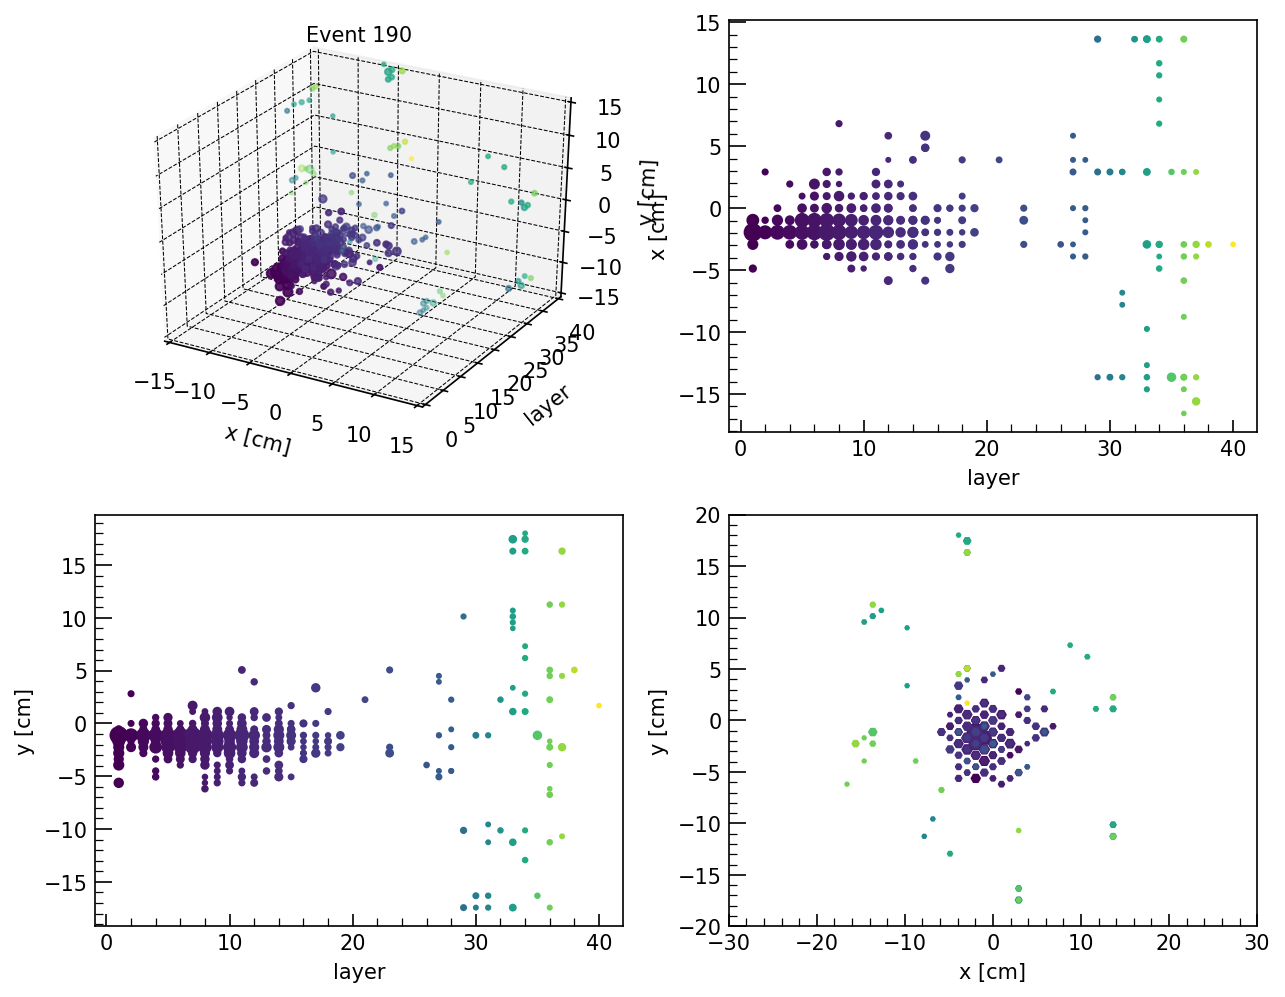

In [13]:
evt_display(df_xyz, event)

### DAQ: High vs low gain amplitudes

A more quantitative check, still at the level of DAQ and reconstruction, can be done by looking at the high vs low gain amplitudes: in an ideal regime, we would expect our chips to show a linear relation between these two quantities, until the saturation of the HG. Hence, we load the corresponding columns from our dataframe and we plot the HG vs LG relation:

In [14]:
x = df.rechit_amplitudeLow
y = df.rechit_amplitudeHigh

In [15]:
ybin = np.linspace(0, 3200, 100)
xbin = np.linspace(0, 800, 100)

Text(0, 1.0, 'High gain [ADC]')

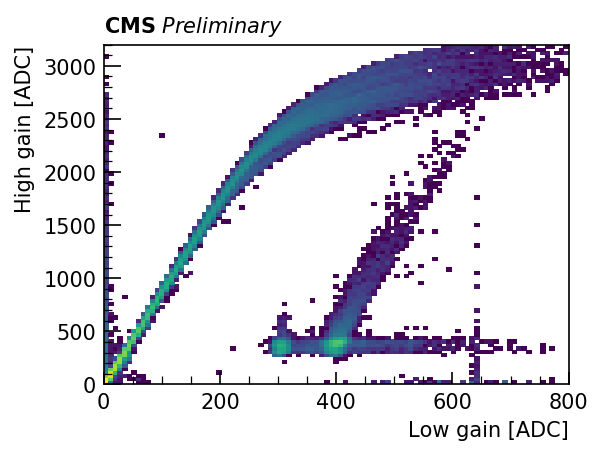

In [16]:
plt.figure(figsize = (4, 3))
plt.title(r'$\bf{{CMS}}$' ' Preliminary', style = 'italic', loc = 'left', fontsize = 10)
t = plt.hist2d(x, y, bins = (xbin, ybin), norm = LogNorm())
plt.xlabel('Low gain [ADC]', ha='right', x=1.0)
plt.ylabel('High gain [ADC]', ha='right', y=1.0)

In [17]:
def plt_ADC_chips(df):
    chips = range(0,4)
    div = int(np.round(np.sqrt(len(chips))))
    
    fig, axs = plt.subplots(1, 4, figsize = (8,2))
    base_sel = df.rechit_energy > 0.5
    norm = plt.Normalize()

    ybin = np.linspace(0, 3200, 100)
    xbin = np.linspace(0, 800, 100)
    
    for i,chip in enumerate(chips):
        ax = axs[i]

        sel = base_sel & (df.rechit_chip == chip)

        x = df[sel].rechit_amplitudeLow
        y = df[sel].rechit_amplitudeHigh

        ax.set_title(r'$\bf{{CMS}}$ Preliminary' '\t  Chip %i'%i, style = 'italic', loc = 'left', fontsize = 6)
        t = ax.hist2d(x, y, bins = (xbin, ybin), norm = LogNorm())
        ax.set_xlabel('Low gain [ADC]', ha='right', x=1.0)
        if i == 0:
            ax.set_ylabel('High gain [ADC]', ha='right', y=1.0)
        else:
            ax.tick_params( axis='y', labelleft = False)

Plotting the ADC distributions for every single chip, we see that the problem spotted above is localized in chip 0. To investigate deeper this issue, we can check if it is localized at any specific layer by looking at the *occupancy* plots, i.e. the distribution of the reconstructed hits in the x, y plane, as a function of their energy.

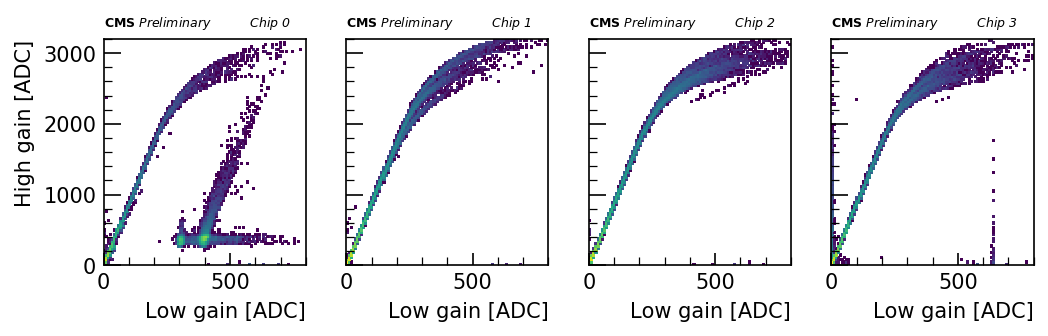

In [18]:
plt_ADC_chips(df)

In [19]:
def plt_occupancy():
    norm = plt.Normalize()
    cmap = 'hot'
    mstyle = 'H'

    zval = 'rechit_energy'

    layers = range(1,5)
    div = int(np.round(np.sqrt(len(layers))))

    nrows = len(layers)//div if len(layers)%div == 0 else len(layers)//div +1
    ncols = div

    fig, axs = plt.subplots(nrows,ncols,figsize = (4,4))
    base_sel = df.rechit_energy > 0.5
    norm = plt.Normalize()
    
    for i,lay in enumerate(layers):

        ax = axs[i//div][i%div]

        ax.set_title('CE-E layer %i' % (lay), fontsize = 9)

        sel = base_sel & (df.rechit_layer == lay)

        cnts = df[sel].groupby(['rechit_x','rechit_y'])['rechit_energy'].sum().reset_index()

        c = np.log(cnts['rechit_energy'])
        #c = cnts[zval]

        im = ax.scatter(cnts.rechit_x, cnts.rechit_y, c = c, marker = mstyle, s = 55, cmap = cmap, norm = norm)

        ax.set_xlim(-10,10)
        ax.set_ylim(-10,10)
        ax.tick_params(axis='both', which='major', labelsize=8)
    fig.subplots_adjust(left=0.05, right=0.85, bottom = 0.05)
    cbar_ax = fig.add_axes([0.9,0.05, 0.025, 0.8])
    fig.colorbar(im, cax=cbar_ax)#, orientation='horizontal')

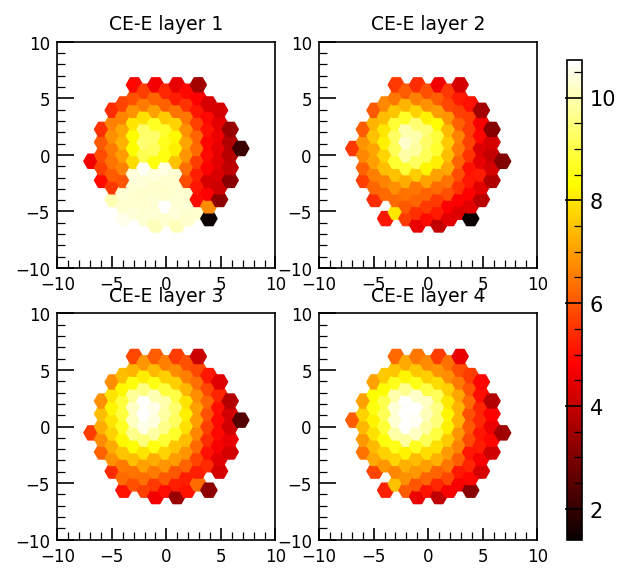

In [20]:
plt_occupancy()

In [21]:
def plt_module():
    plt.figure(figsize = (4, 3))
    mstyle = 'H'
    norm = plt.Normalize()
    layers = range(0,4)
    div = int(np.round(np.sqrt(len(layers))))

    nrows = len(layers)//div if len(layers)%div == 0 else len(layers)//div +1
    ncols = div
    plt.title(r'$\bf{{CMS}}$' ' Preliminary', style = 'italic', loc = 'left', fontsize = 10)
    base_sel = df.rechit_energy > 0.5
    norm = plt.Normalize()
    colors = ['b', 'r', 'k', 'g']
    labels = ['Chip 0', 'Chip 1', 'Chip 2', 'Chip 3']
    for i,lay in enumerate(layers):
        color = colors[i]

        sel = base_sel & (df.rechit_layer == 1) & (df.rechit_chip == lay)

        cnts = df[sel].groupby(['rechit_x','rechit_y'])['rechit_energy'].sum().reset_index()

        im = plt.scatter(cnts.rechit_x, cnts.rechit_y, c = color, marker = mstyle, s = 75)

    plt.legend(labels, bbox_to_anchor=(1, 1))
    plt.xlabel('x position [cm]', ha='right', x=1.0)
    plt.ylabel('y position [cm]', ha='right', y=1.0)


Having seen that the problem seems to be localized in layer 1, we can cross check what learnt above by looking at the distribution of the cells belonging to the different chips:

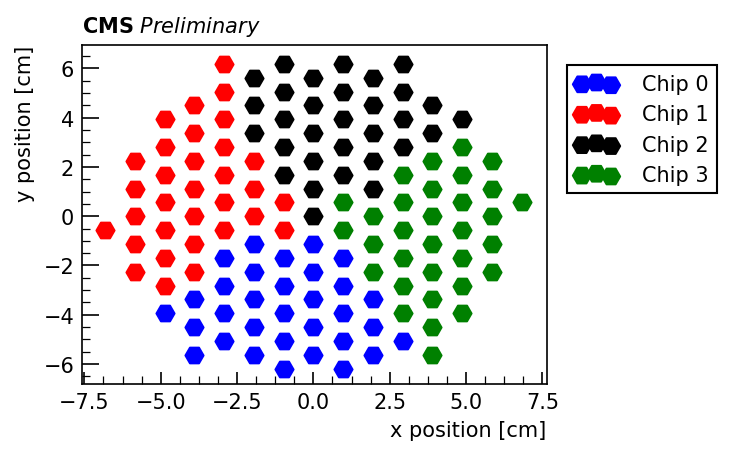

In [22]:
plt_module()

In [23]:
sel = ~((df.rechit_module == 78) & (df.rechit_chip == 0))

Text(0, 1.0, 'High gain [ADC]')

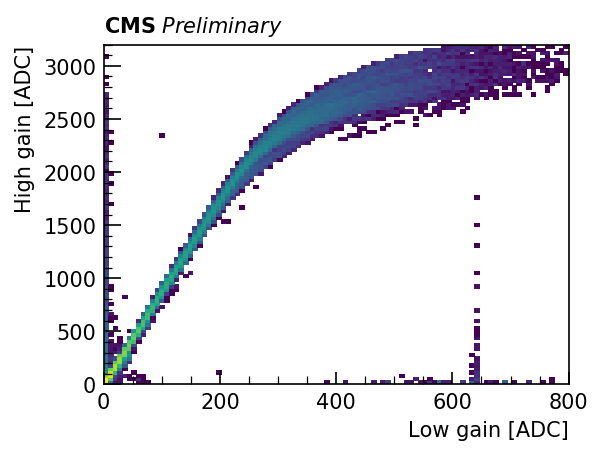

In [24]:
plt.figure(figsize = (4, 3))
plt.title(r'$\bf{{CMS}}$' ' Preliminary', style = 'italic', loc = 'left', fontsize = 10)
t = plt.hist2d(x[sel], y[sel], bins = (xbin, ybin), norm = LogNorm())
plt.xlabel('Low gain [ADC]', ha='right', x=1.0)
plt.ylabel('High gain [ADC]', ha='right', y=1.0)

### The result of DQM studies: spotting and masking bad features in Data

What we have seen so far is a typical usecase of Jupyter notebooks during a test beam campaign. In these cases, you are more interested in producing many plots, all accessible at the same time, to check the quality of your data and to investigate in a subsequential way your results, going more and more in the details. 

In this specific case, the problem was actually a hardware one: the chip 0 of the first layer was broken, and this caused it having a biased response. Having figured this out, we can check what happens to our DQM plots, once this feature is masked in data:

In [25]:
sel = ~((df.rechit_module == 78) & (df.rechit_chip == 0))
sel &= df.rechit_energy > 0.5

df_xyz = df[sel].loc[event]

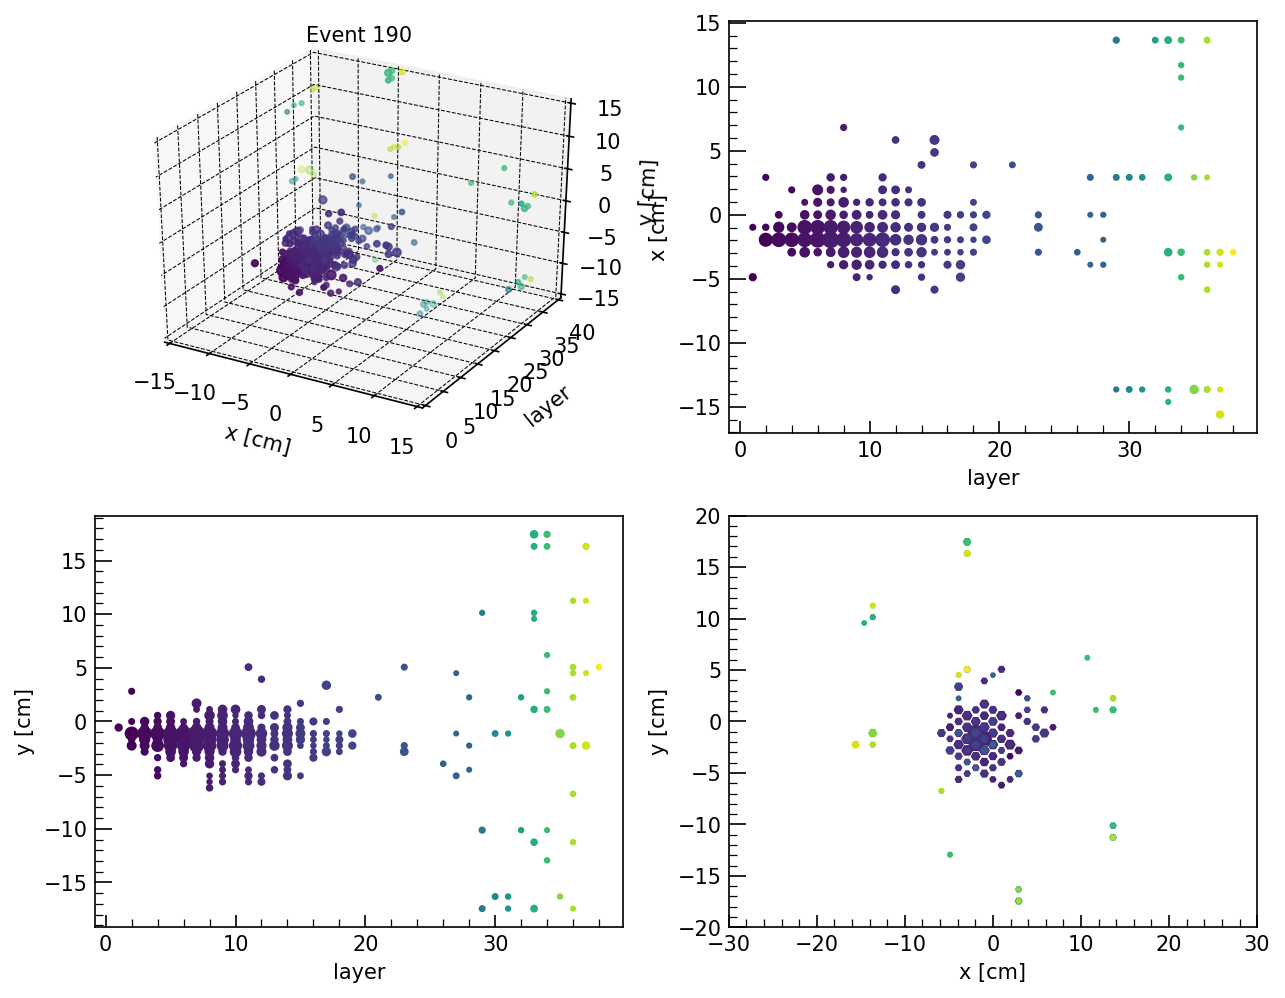

In [26]:
evt_display(df_xyz, event)

In [27]:
binning = 100

## Effect of DQM studies on physics observables

Having spot some problems at a fundamental level in our data, leads us to the question of how the main physics observables are going to be affected. Hence, we can have a look at the *reconstructed energy* and *longitudinal profiles* distributions to start having an insight of what to expect during the data analysis phase.

In [28]:
def plt_esums(esum, esum_mask, esum_mc):
    plt.figure(figsize = (6, 3))
    plt.title(r'$\bf{{CMS}}$' ' Preliminary', style = 'italic', loc = 'left', fontsize = 10)

    t = plt.hist(esum, bins = binning, density = True, histtype = 'step', label = 'Raw E sum', color = 'k')
    t = plt.hist(esum_mask, bins = binning, density = True, histtype = 'step', label = 'Chip 0, Lay 1 removed', color = 'r')
    t = plt.hist(esum_mc, bins = binning, density = True, histtype = 'step', label = 'Simulation', color = 'darkorange')
    plt.xlabel('Reconstructed Energy [MIP]', ha='right', x=1.0)
    plt.legend(loc = 2)
    
def plt_longProfs(lp, lp_mask, lp_mc):
    plt.figure(figsize = (6, 3))
    plt.title(r'$\bf{{CMS}}$' ' Preliminary', style = 'italic', loc = 'left', fontsize = 10)
    t = plt.plot(lp, 'k.--', label = 'Raw E sum')
    t = plt.plot(lp_mask, 'r.--', label = 'Chip 0, Lay 1 removed')
    t = plt.plot(lp_mc, marker = '.', linestyle = '--', label = 'Simulation', color = 'darkorange')
    plt.legend()
    plt.xlabel('Layer number', ha='right', x=1.0)
    plt.ylabel('Average energy [MIP]', ha='right', y=1.0)

In [29]:
esum = get_totE(df)

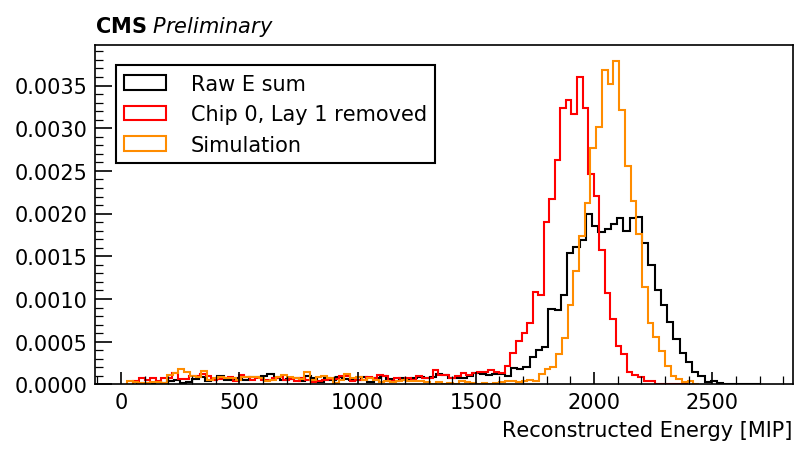

In [30]:
esum_mask = get_totE(df[sel])
esum_mc = get_totE(df_mc)
plt_esums(esum, esum_mask, esum_mc)

In [31]:
SF = (1-np.median(esum_mask)/np.median(esum_mc))*100
print('Energy response between Data and Simulation is off by %.2f %%' %(SF))

Energy response between Data and Simulation is off by 8.02 %


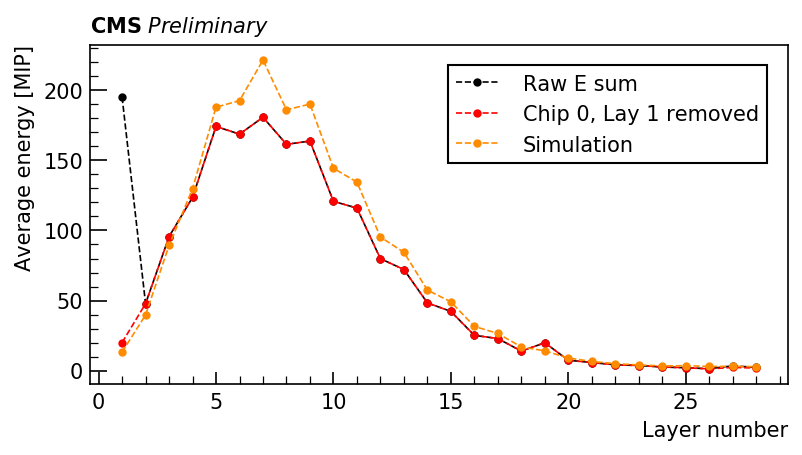

In [32]:
ecal = df.rechit_layer < 29
lp = get_longProf(df[ecal])
lp_mask = get_longProf(df[sel & ecal])
ecal = df_mc.rechit_layer < 29
lp_mc = get_longProf(df_mc[ecal])

plt_longProfs(lp, lp_mask, lp_mc)

## Offline analysis: from reconstructed data to the final results

The exploratory analysis conducted during the test beam campaign, and after the data reconstruction, is fundamental to understand which features need to be masked, which selection criteria we want to apply to our data and to define a strategy for the final statistical analysis. 
In many cases, it could be useful to define some external libraries, such as the `hgcalsw` here, to help us in this second part of our work:

In [33]:
from hgcalsw.data import read_ntuple as do_df
from hgcalsw.utils import observables as obs
from hgcalsw.fit import fit_functions as fit
from scipy.optimize import curve_fit
from tqdm import tqdm

In [34]:
def plt_resolution(beam_E, resolution, error, c = 'k', label = 'Data'):
    error = np.sqrt(np.array(error)**2 + (0.025*np.array(resolution))**2)
    plt.errorbar(true_E, resolution, yerr = error, color = c, marker = '.', linestyle = 'None', label = label)

    beam_E = np.array(true_E); resolution = np.array(resolution)
    
    xdraw = np.linspace(18, 300, 100)
    popt, pcov = curve_fit(fit.resolution, beam_E, resolution, sigma = error, absolute_sigma=True)
    plt.plot(xdraw, fit.resolution(xdraw, *popt), linestyle = '--', color = c)
    plt.legend()
    plt.xlabel('Beam energy [GeV]', ha='right', x=1.0)
    plt.ylabel('Average energy [MIP]', ha='right', y=1.0)

### Inputs for the statistical analysis: large amount of data

The final measurements are going to be extracted by means of a statistical analysis, supported by a comparison between our data and a Monte Carlo simulation. First of all, we have to load the sample corresponding to the different beam energies acquired:

In [35]:
energies = np.array([20, 30, 50, 80, 100, 120, 150, 200, 250, 300])
true_E   = np.array([20, 30, 49.99, 79.93, 99.83, 119.20, 149.14, 197.32, 243.61, 287.18])
runs = {20: 455, 30: 596, 50: 458, 80: 469, 100: 490, 120: 620, 150: 494, 200: 664, 250: 653, 300: 435}

For example, if we want to study the energy resolution of our calorimeter, we can use the `obs.doEsum()` function of our library, which reads all the samples, apply the preselection cuts for this analysis (e.g. the masking of chip 0, layer 1 we have seen above) and returns the reconstructed energy distributions:

In [36]:
esums = {}
for energy in tqdm(energies):
    run = runs[energy]
    fname = data_prefix + 'ntuple_%i.root' %run
    esums[energy] = pd.Series(obs.doEsum(fname))

100%|██████████| 10/10 [00:22<00:00,  2.24s/it]


In [37]:
esums_mc = {}
for energy in tqdm(energies):
    fname = sim_prefix + 'ntuple_sim_config22_pdgID11_beamMomentum%i_listFTFP_BERT_EMN_0000_0.root' %energy
    esums_mc[energy] = pd.Series(obs.doEsum(fname, isMC = True))

100%|██████████| 10/10 [00:24<00:00,  2.44s/it]


In [38]:
energy = 80
es_dt = esums[energy]
es_mc = esums_mc[energy]

In [39]:
def plt_esums(energy):
    energy = 80
    es_dt = esums[energy]
    es_mc = esums_mc[energy]
    e_med = np.median(es_mc)

    binning = np.linspace(e_med*0.6, e_med*1.2, 100)
    
    plt.figure(figsize = (4, 3))
    plt.title(r'$\bf{{CMS}}$' ' Preliminary', style = 'italic', loc = 'left', fontsize = 10)

    t = plt.hist(es_dt, bins = binning, density = True, histtype = 'step', label = 'Data', color = 'k')
    t = plt.hist(es_mc, bins = binning, density = True, histtype = 'step', label = 'Simulation', color = 'r')

    plt.legend(loc = 2)
    plt.xlabel('Reconstructed Energy [MIP]', ha='right', x=1.0, fontsize = 8)

## Measuring the energy resolution

To measure the energy resolution of our calorimeter, we perform an iterative gaussian fit of the reconstructed energy distributions to extract the ratio between the mean ($\left\langle E\right\rangle$) and the standard deviation ($\sigma_E$).

Here we show an example of the energy distributions for a beam energy of 80 GeV, along with the result of the gaussian fit used to measure the final resolution:

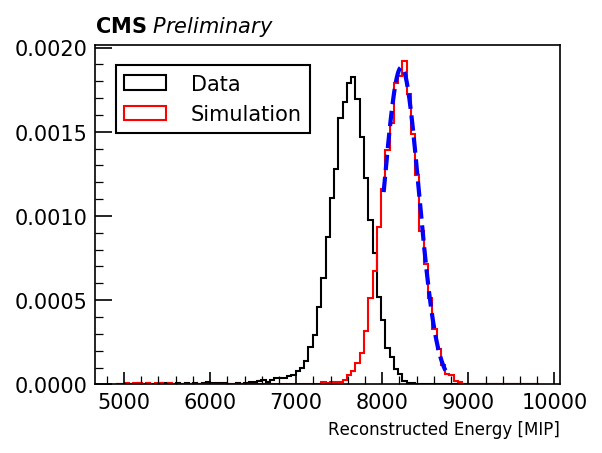

In [40]:
energy = 80
plt_esums(energy)
r = fit.repeatedGausFit(es_mc, energy, drawFit=True, c = 'b')

We use our external library to perform the measurement of the energy resolution as detailed above. As a final step of the statistical analysis, we want to compare the results for data and simulation:

In [41]:
res = []; res_mc = []
err = []; err_mc = []
for energy, beam_energy in zip(energies, true_E):
    es_dt = esums[energy]; es_mc = esums_mc[energy]
    r = fit.repeatedGausFit(es_dt, energy)
    res.append(r[0]); err.append(r[1])
    
    r = fit.repeatedGausFit(es_mc, energy)
    res_mc.append(r[0]); err_mc.append(r[1])

### Jupyter notebooks from top to bottom: the final result 

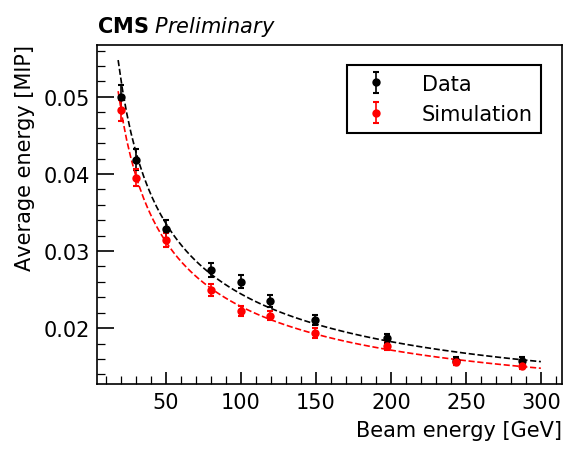

In [42]:
plt.figure(figsize = (4, 3))
plt.title(r'$\bf{{CMS}}$' ' Preliminary', style = 'italic', loc = 'left', fontsize = 10)

plt_resolution(true_E, res, err, label = 'Data')
plt_resolution(true_E, res_mc, err_mc, c = 'r', label = 'Simulation')